In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import correlate, find_peaks
import sounddevice as sd
import wave
# matplotlib qt

# Microphone Parameters
1. Mic Gain: 80
2. Recording Mode: Ambisonics FuMa
3. Recording Format (Sampling Rate): 48kHz
4. Recording Format (Bit depth): 24-bit

In [39]:
# Step 1: Define the parameters

# Reference: Patricio et. al in [14] E. Patricio, A. Ruminski, A. Kuklasinski, 
# L. Januszkiewicz, and T. Zernicki, "Toward Six Degrees of Freedom Audio 
# Recording and Playback Using Multiple Ambisonics Sound Fields," Paper 10141, 
# (2019 March.)

# Number of microphones
M = 3

# Order of Ambisonics
# We are using first order ambisonics in FuMa Format
# Note: WAV Format: W,X,Y,Z
P = 1

# Placing the ambisonic microphones in a triangle, this is the length of the 
# triangle (in centimeters)
triangle_side = 128

# Constants for the attenuation function
volume_threshold = 0.9
volume_range = 0.9
hoa_threshold = 0.9
hoa_range = 1.3

# Defining the indices of the channel
w_channel = 0
x_channel = 1
y_channel = 2
z_channel = 3

# Defining the microphone positions as a global parameter
mic_positions = np.zeros((3, 2))

mic_positions[0, :] = [0, 0]
mic_positions[1, :] = [triangle_side, 0]
mic_positions[2, :] = [triangle_side / 2, (triangle_side * np.sqrt(3)) / 2]

# 2. Defining the functions

Here will contain all the functions which I will use for the application

In [40]:

def attenuation_and_rebalancing(d_m, t_l=volume_threshold, t_k=hoa_range, s_k_0=1.0, s_k_p_neg=-1.0, s_l_neg=-1.0):
    """
    Distance-dependent attenuation and component re-balancing function.

    Parameters:
    - d_m: distance to the m-th microphone
    - t_l: attenuation threshold
    - t_k: re-balancing threshold
    - s_k_0: slope for the 0th order component
    - s_k_p_neg: slope for higher-order components (p>0)
    - s_l_neg: slope for overall gain

    Returns:
    - Attenuation coefficient for the given distance
    """
    def l(d_m):
        # Piecewise function where: 
        # l(d_m) = 0 if d_m <= t_l
        # l(d_m) = s_l(d_m - t_l) otherwise
        return np.where(d_m <= t_l, 0, s_l(d_m - t_l))

    def k_p(d_m):
        # Piecewise function where: 
        # k_p(d_m) = 0 if d_m <= t_k
        # k_p(d_m) = s_k_p(d_m - t_k) otherwise
        return np.where(d_m <= t_k, 0, s_k_p(d_m - t_k))

    def s_l(delta_d):
        # Adjust this function based on the specific behavior of s_l
        # For example, you can use a linear function: return s_l_neg * delta_d
        return s_l_neg * delta_d

    def s_k_p(delta_d):
        # Adjust this function based on the specific behavior of s_k_p
        # For p=0, the slope is positive; for p>0, the slope is negative
        return np.where(delta_d <= 0, s_k_0, s_k_p_neg * delta_d)

    return 10 ** ((l(d_m) + k_p(d_m)) / 20.0)

# Function to compute the distance between the interpolation points and the microphone
def compute_distance(interp_point, mic_number, triangle_side):
    
    # Euclidean distance between the interpolation point and the microphone

    distance = np.linalg.norm(interp_point - mic_positions[mic_number, :])
    return distance

# Function to extract the w, x, y, z channel signals
def extract_channels(mic_signal):
    # W Channel (Omni directional)
    w_signal = mic_signal[:, w_channel].astype(float)
    # X Channel
    x_signal = mic_signal[:, x_channel].astype(float)
    # Y Channel
    y_signal = mic_signal[:, w_channel].astype(float)
    # Z Channel
    z_signal = mic_signal[:, w_channel].astype(float)

    return w_signal, x_signal, y_signal, z_signal

# Getting the minimum length of the signals
def get_min_length(mic1_signal, mic2_signal, mic3_signal):
    return min(len(mic1_signal), len(mic2_signal), len(mic3_signal))



# 3. Getting the raw microphone data from the three microphones

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_73331/785767053.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, mic1_signal = wavfile.read('../data/02_14/mic1.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_73331/785767053.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic2_signal = wavfile.read('../data/02_14/mic2.WAV')
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_73331/785767053.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, mic3_signal = wavfile.read('../data/02_14/mic3.WAV')


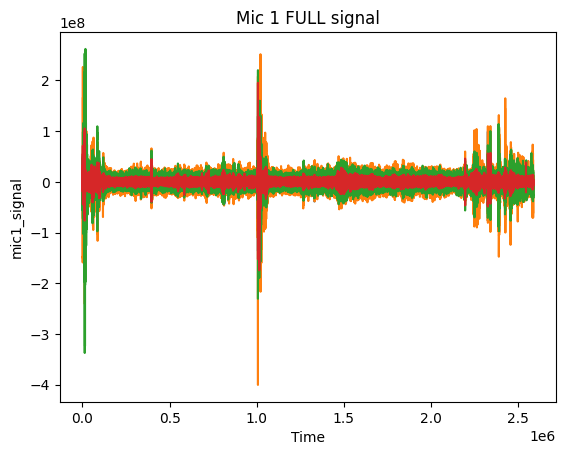

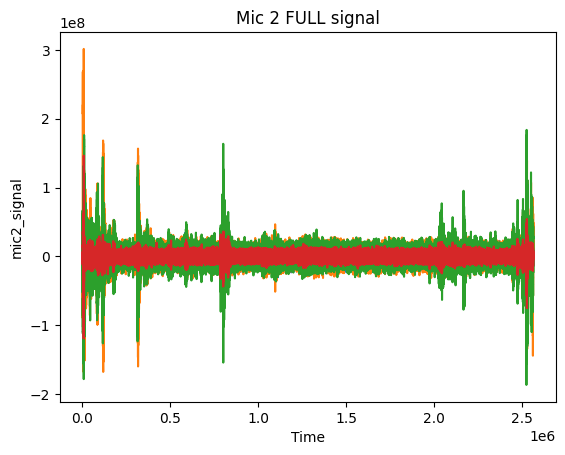

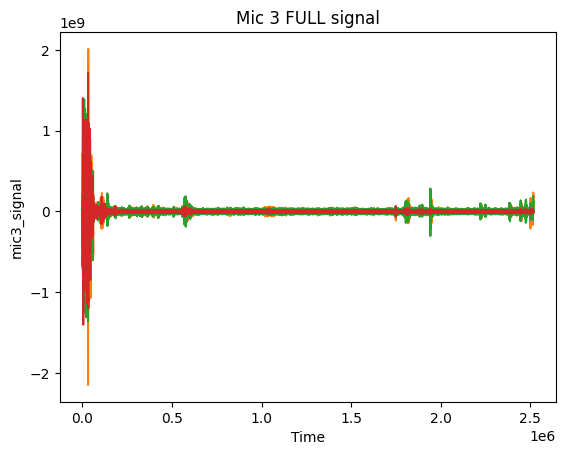

In [41]:
import numpy as np
import scipy.signal
from scipy.io import wavfile

# Getting the wav files
fs, mic1_signal = wavfile.read('../data/02_14/mic1.WAV')
_, mic2_signal = wavfile.read('../data/02_14/mic2.WAV')
_, mic3_signal = wavfile.read('../data/02_14/mic3.WAV')

# Getting the time axis for plotting purposes
time_axis_1 = np.arange(1, len(mic1_signal) + 1)
time_axis_2 = np.arange(1, len(mic2_signal) + 1)
time_axis_3 = np.arange(1, len(mic3_signal) + 1)

# Plotting the signals
plt.plot(time_axis_1, mic1_signal)
plt.title('Mic 1 FULL signal')
plt.xlabel('Time')
plt.ylabel('mic1_signal')
plt.show()

plt.plot(time_axis_2, mic2_signal)
plt.title('Mic 2 FULL signal')
plt.xlabel('Time')
plt.ylabel('mic2_signal')
plt.show()


plt.plot(time_axis_3, mic3_signal)
plt.title('Mic 3 FULL signal')
plt.xlabel('Time')
plt.ylabel('mic3_signal')
plt.show()

# 4. Extracting the individual components of the signal

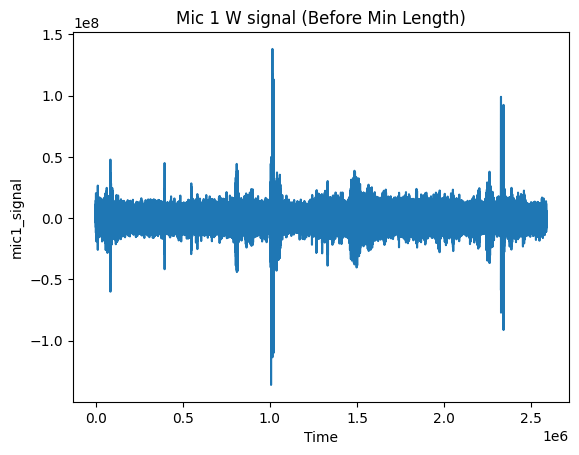

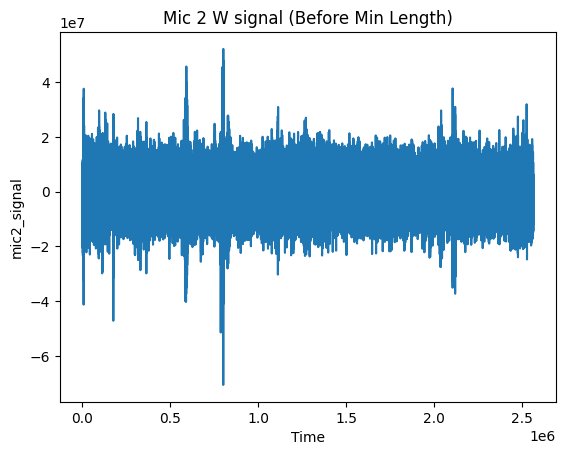

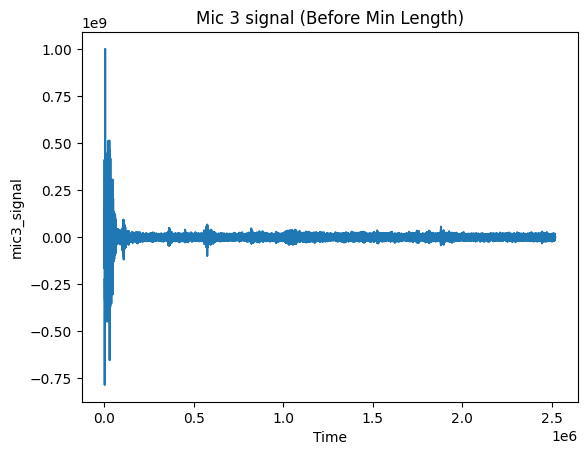

In [42]:
# Extracting the data from each channel
mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal = extract_channels(mic1_signal)
mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal = extract_channels(mic2_signal)
mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal = extract_channels(mic3_signal)

# Making the microphone signals all the same length as the lowest one
min_w_length = get_min_length(mic1_w_signal, mic2_w_signal, mic3_w_signal)
min_x_length = get_min_length(mic1_x_signal, mic2_x_signal, mic3_x_signal)
min_y_length = get_min_length(mic1_y_signal, mic2_y_signal, mic3_y_signal)
min_z_length = get_min_length(mic1_z_signal, mic2_z_signal, mic3_z_signal)
assert(min_w_length == min_x_length == min_y_length == min_z_length)

min_length = min_w_length # Once we confirmed that the channel lengths are the same

plt.plot(time_axis_1, mic1_w_signal)
plt.title('Mic 1 W signal (Before Min Length)')
plt.xlabel('Time')
plt.ylabel('mic1_signal')
plt.show()

plt.plot(time_axis_2, mic2_w_signal)
plt.title('Mic 2 W signal (Before Min Length)')
plt.xlabel('Time')
plt.ylabel('mic2_signal')
plt.show()


plt.plot(time_axis_3, mic3_w_signal)
plt.title('Mic 3 signal (Before Min Length)')
plt.xlabel('Time')
plt.ylabel('mic3_signal')
plt.show()

# Making all the signals the minimum length
# Mic 1
mic1_w_signal = mic1_w_signal[:min_length]
mic1_x_signal = mic1_x_signal[:min_length]
mic1_y_signal = mic1_y_signal[:min_length]
mic1_z_signal = mic1_z_signal[:min_length]

# Mic 2
mic2_w_signal = mic2_w_signal[:min_length]
mic2_x_signal = mic2_x_signal[:min_length]
mic2_y_signal = mic2_y_signal[:min_length]
mic2_z_signal = mic2_z_signal[:min_length]

# Mic 3
mic3_w_signal = mic3_w_signal[:min_length]
mic3_x_signal = mic3_x_signal[:min_length]
mic3_y_signal = mic3_y_signal[:min_length]
mic3_z_signal = mic3_z_signal[:min_length]

# @TODO: Let's just see if we can re-create the signals
matrix_1 = np.column_stack((mic1_w_signal, mic1_x_signal, mic1_y_signal, mic1_z_signal))
matrix_2 = np.column_stack((mic2_w_signal, mic2_x_signal, mic2_y_signal, mic2_z_signal))
matrix_3 = np.column_stack((mic3_w_signal, mic3_x_signal, mic3_y_signal, mic3_z_signal))

# Generating the wav files from the matrix
matrices = [matrix_1, matrix_2, matrix_3]
# output_filenames = ["output_mic1.wav", "output_mic2.wav", "output_m3.wav"]

for i in range(len(matrices)):
    wavfile.write(f'intermediate_mic{i+1}.wav', fs, matrices[i])


# 5. Normalizing the w signals

ValueError: x and y must have same first dimension, but have shapes (2587520,) and (2518272,)

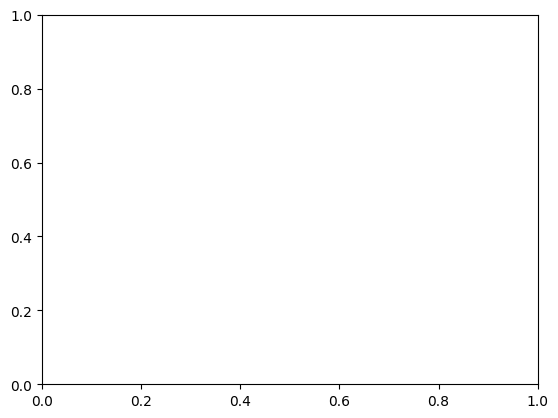

In [48]:
# Finding the gains of the microphones
# Calculate RMS value for each signal
gain_mic1 = np.mean(np.abs(mic1_w_signal))
gain_mic2 = np.mean(np.abs(mic2_w_signal))
gain_mic3 = np.mean(np.abs(mic3_w_signal))

max_gain = max(gain_mic1, gain_mic2, gain_mic3)
normalization_factor = 1.0 / max_gain

time_axis = np.arange(1, len(mic1_w_signal) + 1)

normalized_mic1 = mic1_w_signal * normalization_factor
normalized_mic2 = mic2_w_signal * normalization_factor
normalized_mic3 = mic3_w_signal * normalization_factor

# Plotting the signals
plt.plot(time_axis, normalized_mic1)
plt.title('Mic 1 W signal NORMALIZED')
plt.xlabel('Time')
plt.ylabel('mic1_signal')
plt.show()

plt.plot(time_axis, normalized_mic2)
plt.title('Mic 2 W signal NORMALIZED')
plt.xlabel('Time')
plt.ylabel('mic2_signal')
plt.show()


plt.plot(time_axis, normalized_mic3)
plt.title('Mic 3 W signal NORMALIZED')
plt.xlabel('Time')
plt.ylabel('mic3_signal')
plt.show()

# Finding correlation and time delays

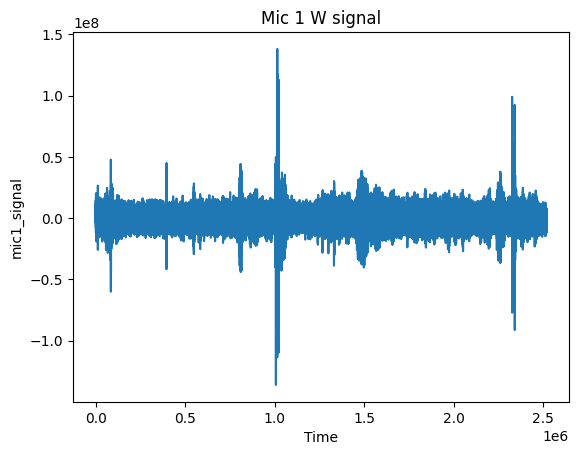

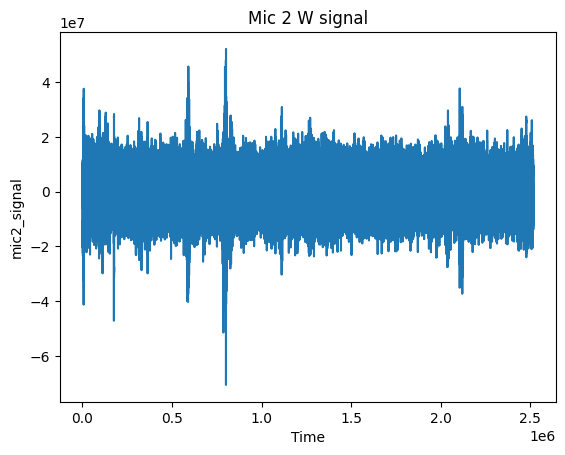

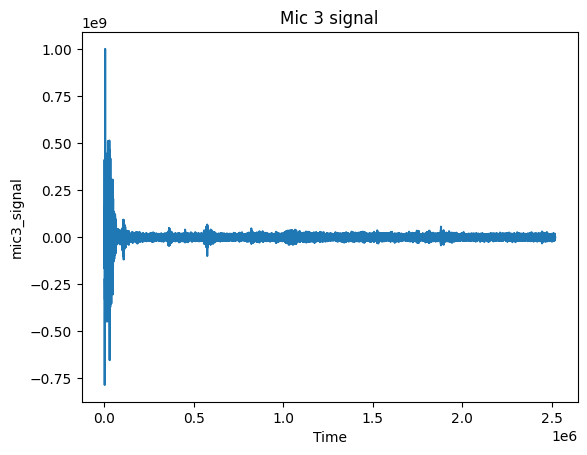

Correlation12: [-1.60138543e+18-1292.2934251j  -1.57879481e+18-1217.28922205j
 -1.55638633e+18-1232.52154343j ... -1.66966148e+18-1368.75947773j
 -1.64670606e+18-1369.13753387j -1.62418617e+18-1220.85183112j]
Correlation13: [-8.82932837e+18+3847.28312787j -8.91455753e+18+3690.53714254j
 -8.99423194e+18+3854.93810398j ... -8.55705214e+18+3012.76271767j
 -8.64956873e+18+3046.24363192j -8.74056089e+18+3059.68057587j]
Correlation23: [3.16186527e+18+2434.08386551j 3.48282577e+18+2697.98754854j
 3.80937511e+18+2044.11568415j ... 2.23843770e+18 +794.37219978j
 2.53949007e+18+2480.40935281j 2.84747126e+18+2880.72064301j]
Time delay between mic1 and mic2: 4.60156 seconds
Time delay between mic1 and mic3: 0.97765 seconds
Time delay between mic2 and mic3: 52.44796 seconds


In [43]:


# Regenerating the wav files from the signals
# Perform the Fourier transform of the omnidirectional signals
f_mic1 = np.fft.fft(mic1_w_signal)
f_mic2 = np.fft.fft(mic2_w_signal)
f_mic3 = np.fft.fft(mic3_w_signal)

# # Calculate cross-correlation in the frequency domain
# # np.conj: Finds the complex conjugate of the fourier transform

correlation12 = np.fft.ifft(f_mic1 * np.conj(f_mic2))
correlation13 = np.fft.ifft(f_mic1 * np.conj(f_mic3))
correlation23 = np.fft.ifft(f_mic2 * np.conj(f_mic3))

time_axis = np.arange(1, len(mic1_w_signal) + 1)
plt.plot(time_axis, mic1_w_signal)
plt.title('Mic 1 W signal')
plt.xlabel('Time')
plt.ylabel('mic1_signal')
plt.show()

plt.plot(time_axis, mic2_w_signal)
plt.title('Mic 2 W signal')
plt.xlabel('Time')
plt.ylabel('mic2_signal')
plt.show()


plt.plot(time_axis, mic3_w_signal)
plt.title('Mic 3 signal')
plt.xlabel('Time')
plt.ylabel('mic3_signal')
plt.show()

# Plot the correlation

print(f'Correlation12: {correlation12}')
print(f'Correlation13: {correlation13}')
print(f'Correlation23: {correlation23}')

# Find the lag with maximum correlation
lag12 = np.argmax(np.abs(correlation12))
lag13 = np.argmax(np.abs(correlation13))
lag23 = np.argmax(np.abs(correlation23))



# Calculate time delays
delay12 = lag12 / fs
delay13 = lag13 / fs
delay23 = lag23 / fs

print(f'Time delay between mic1 and mic2: {delay12:.5f} seconds')
print(f'Time delay between mic1 and mic3: {delay13:.5f} seconds')
print(f'Time delay between mic2 and mic3: {delay23:.5f} seconds')

lag = np.array([lag13, lag23, 0])

In [44]:
# Step 2: Load your ambisonic signals y_m_p(n) from WAV files
path_to_files = '../data/02_14/'
file_names = ['mic1.wav', 'mic2.wav', 'mic3.wav']  # Adjust with your file names

# Initialize an array to store ambisonic signals
max_samples = max([wavfile.read(path_to_files + file_name)[1].shape[0] for file_name in file_names])
y_m_p = np.zeros((M, P, max_samples))  # Initialize with the maximum number of samples


for m in range(M):
    # Read the WAV file
    fs, y = wavfile.read(path_to_files + file_names[m])
    
    y = y[lag[m]: , :]
    
    # Take the 4 channels 
    y_m_p[m, :, :y.shape[0]] = y[:, :P].T

# Step 3: Implement the interpolation algorithm

# Number of samples
N = y_m_p.shape[2]

# Initialize the interpolated signal
x_p = np.zeros(N)

/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_73331/3407659793.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  max_samples = max([wavfile.read(path_to_files + file_name)[1].shape[0] for file_name in file_names])
/var/folders/z7/38nrk_xn0gg2mnhxz1rbjtt00000gn/T/ipykernel_73331/3407659793.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, y = wavfile.read(path_to_files + file_names[m])


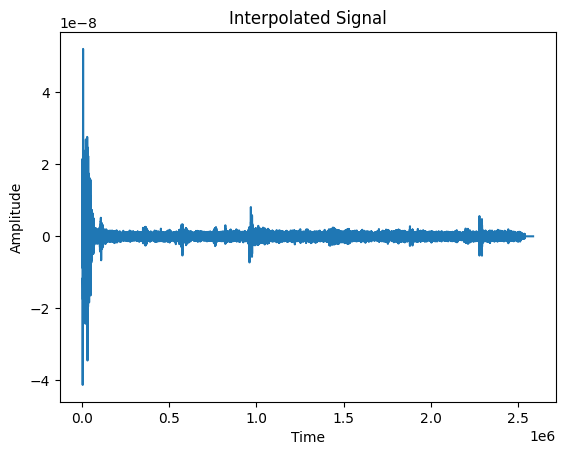

In [45]:
# Interpolation point coordinates

interp_point = np.array([triangle_side / 2, (triangle_side * np.sqrt(3)) / 6])  # centroid
# interp_point =  [1.05, (triangle_side * np.sqrt(3)) / 6]

# Initialize an array to store the attenuation coefficients for each microphone
a_p_values = np.zeros((M, N))

# Compute the distance for all samples at once
distances = np.array([compute_distance(interp_point, m, triangle_side) for m in range(M)])

# Compute the attenuation coefficients for each microphone using broadcasting
a_p_values = attenuation_and_rebalancing(distances[:, np.newaxis])

# Update the interpolated signal using vectorized NumPy operations
x_p = np.sum(a_p_values[:, :, np.newaxis] * y_m_p, axis=(0, 1))
x_p = x_p/1000000000.0

# Plot
time_axis = np.arange(1, N + 1)
wavfile.write('output_median4.wav', fs, x_p)
plt.plot(time_axis, x_p)
plt.title('Interpolated Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()